# Programming assignment (Linear models, Optimization)

In this programming assignment you will implement a linear classifier and train it using stochastic gradient descent modifications and numpy.

In [12]:
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

## Two-dimensional classification

To make things more intuitive, let's solve a 2D classification problem with synthetic data.

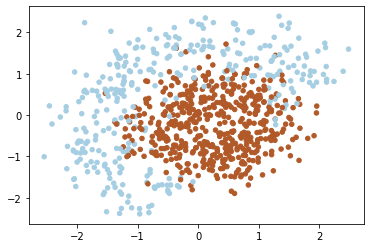

In [13]:
from sklearn import datasets, preprocessing

# keep random_state=42 for deterministic results
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4, random_state=42)
ind = np.logical_or(y == 1, X[:, 1] > X[:, 0] - 0.5)
X = X[ind, :]
m = np.array([[1, 1], [-2, 1]])
X = preprocessing.scale(X)
y = y[ind]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
plt.show()

# Task

## Features

As you can notice the data above isn't linearly separable. Since that we should add features (or use non-linear model). Note that decision line between two classes have form of circle, since that we can add quadratic features to make the problem linearly separable. The idea under this displayed on image below:

![](kernel.png)

In [28]:
def expand(X):
    """
    Adds quadratic features. 
    This expansion allows your linear model to make non-linear separation.
    
    For each sample (row in matrix), compute an expanded row:
    [feature0, feature1, feature0^2, feature1^2, feature1*feature2, 1]
    
    :param X: matrix of features, shape [n_samples,2]
    :returns: expanded features of shape [n_samples,6]
    """
    X_expanded = np.zeros((X.shape[0], 6))
    X_expanded[:,:2] = X
    X_expanded[:, 2] = np.power(X[:,0], 2)
    X_expanded[:, 3] = np.power(X[:,1], 2)
    X_expanded[:, 4] = X[:,0] * X[:,1]
    X_expanded[:, 5] = np.ones(X.shape[0])
    return X_expanded

In [29]:
X_expanded = expand(X)

Here are some tests for your implementation of `expand` function.

In [32]:
#simple test on random numbers

dummy_X = np.array([
        [0,0],
        [1,0],
        [2.61,-1.28],
        [-0.59,2.1]
    ])

#call your expand function
dummy_expanded = expand(dummy_X)

#what it should have returned:   x0       x1       x0^2     x1^2     x0*x1    1
dummy_expanded_ans = np.array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ],
                               [ 1.    ,  0.    ,  1.    ,  0.    ,  0.    ,  1.    ],
                               [ 2.61  , -1.28  ,  6.8121,  1.6384, -3.3408,  1.    ],
                               [-0.59  ,  2.1   ,  0.3481,  4.41  , -1.239 ,  1.    ]])

#tests
assert isinstance(dummy_expanded,np.ndarray), "please make sure you return numpy array"
assert dummy_expanded.shape==dummy_expanded_ans.shape, "please make sure your shape is correct"
assert np.allclose(dummy_expanded,dummy_expanded_ans,1e-3), "Something's out of order with features"

print("Seems legit!")


Seems legit!


## Logistic regression

To classify objects we will obtain probability of object belongs to class '1'. To predict probability we will use output of linear model and logistic function:

$$ a(x; w) = \langle w, x \rangle $$
$$ P( y=1 \; \big| \; x, \, w) = \dfrac{1}{1 + \exp(- \langle w, x \rangle)} = \sigma(\langle w, x \rangle)$$


In [63]:
def probability(X, w):
    """
    Given input features and weights
    return predicted probabilities of y==1 given x, P(y=1|x), see description above
        
    Don't forget to use expand(X) function (where necessary) in this and subsequent functions.
    
    :param X: feature matrix X of shape [n_samples,2] (non-expanded)
    :param w: weight vector w of shape [6] for each of the expanded features
    :returns: an array of predicted probabilities in [0,1] interval.
    """

    return 1/ (1 + np.exp(- (X @ w)))

In [64]:
# use output of this cell to fill answer field 

dummy_weights = np.linspace(-1, 1, 6)
probability(X_expanded[:17,:], dummy_weights)

array([0.38039985, 0.53100076, 0.57466019, 0.7816769 , 0.40812873,
       0.65685624, 0.63380988, 0.71703014, 0.42939941, 0.67283177,
       0.57320716, 0.97069282, 0.73525255, 0.56262557, 0.70636799,
       0.93963294, 0.99348905])

In logistic regression the optimal parameters $w$ are found by cross-entropy minimization:

$$ L(w) =  - {1 \over N} \sum_{i=1}^N \left[ {y_i \cdot log P(y_i \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i\, | \, x_i,w))}\right] $$



In [65]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of 1/0,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    p = probability(X, w)
    return -(y * np.log(p) + (1 - y) * np.log((1-p))).sum() / X.shape[0]

In [66]:
# use output of this cell to fill answer field 
compute_loss(X_expanded, y, dummy_weights)

1.018563403078252

Since we train our model with gradient descent, we should compute gradients.

To be specific, we need a derivative of loss function over each weight [6 of them].

$$ \nabla_w L = ...$$

We won't be giving you the exact formula this time — instead, try figuring out a derivative with pen and paper. 

As usual, we've made a small test for you, but if you need more, feel free to check your math against finite differences (estimate how $L$ changes if you shift $w$ by $10^{-5}$ or so).

In [67]:
def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,6], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    
    m = X.shape[0]
    A = probability(X, w)
    dZ = A - y
    dW = np.dot(dZ, X) / float(m)
    
    return dW

In [68]:
# use output of this cell to fill answer field 
np.linalg.norm(compute_grad(X_expanded, y, dummy_weights))

0.6401687302118624

Here's an auxiliary function that visualizes the predictions:

In [69]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def visualize(X, y, w, history):
    """draws classifier prediction with matplotlib magic"""
    Z = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.subplot(1,2,2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

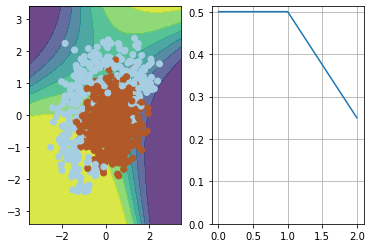

In [70]:
visualize(X, y, dummy_weights, [0.5,0.5,0.25])

## Training
In this section we'll use the functions you wrote to train our classifier using stochastic gradient descent.

You can try change hyperparameters like batch size, learning rate and so on to find the best one, but use our hyperparameters when fill answers.

## SGD

Stochastic gradient descent just takes a random example on each iteration, calculates a gradient of the loss on it and makes a step:
$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$



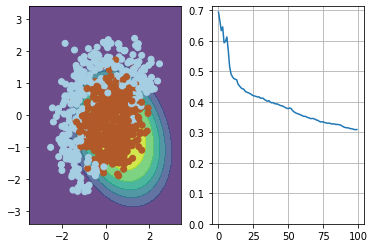

<Figure size 432x288 with 0 Axes>

In [77]:
w = np.array([0,0,0,0,0,1])

eta= 0.1 # learning rate

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    visualize(X_expanded[ind,:], y[ind], w, loss)
    #TODO: <your code here>
    dW = compute_grad(X_expanded[ind, :], y[ind], w)
    w = w - eta * dW 
    
visualize(X, y, w, loss)
plt.clf()

In [78]:
# use output of this cell to fill answer field 

compute_loss(X_expanded, y, w)

0.308673860382169

## SGD with momentum

Momentum is a method that helps accelerate SGD in the relevant direction and dampens oscillations as can be seen in image below. It does this by adding a fraction $\alpha$ of the update vector of the past time step to the current update vector.
<br>
<br>

$$ \nu_t = \alpha \nu_{t-1} + \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$
$$ w_t = w_{t-1} - \nu_t$$

<br>


![](sgd.png)


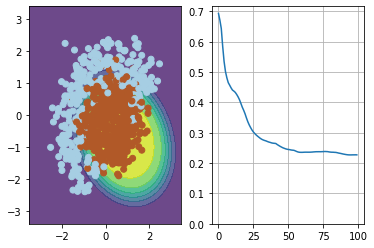

<Figure size 432x288 with 0 Axes>

In [79]:
w = np.array([0,0,0,0,0,1])

eta = 0.05 # learning rate
alpha = 0.9 # momentum
nu = np.zeros_like(w)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    visualize(X_expanded[ind,:], y[ind], w, loss)    
    #TODO: <your code here>
    dW = compute_grad(X_expanded[ind, :], y[ind], w)
    nu = alpha*nu + eta*dW
    w = w - nu

visualize(X, y, w, loss)
plt.clf()

In [80]:
# use output of this cell to fill answer field 

compute_loss(X_expanded, y, w)

0.2271670470594755

## RMSprop

Implement RMSPROP algorithm, which use squared gradients to adjust learning rate:

$$ G_j^t = \alpha G_j^{t-1} + (1 - \alpha) g_{tj}^2 $$
$$ w_j^t = w_j^{t-1} - \dfrac{\eta}{\sqrt{G_j^t + \varepsilon}} g_{tj} $$

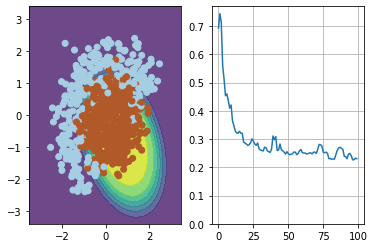

<Figure size 432x288 with 0 Axes>

In [82]:
w = np.array([0, 0, 0, 0, 0, 1.])

eta = 0.1 # learning rate
alpha = 0.9 #moving average of gradient norm squared
G = np.zeros_like(w)
g2 = None
eps = 1e-8

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    visualize(X_expanded[ind,:], y[ind], w, loss)
    #TODO: <your code here>
    dW = compute_grad(X_expanded[ind, :], y[ind], w)
    g2 = np.power(dW, 2)
    G = alpha*G + (1-alpha)*g2
    
    w = w - eta*dW/np.sqrt(G+eps)

visualize(X, y, w, loss)
plt.clf()

In [83]:
# use output of this cell to fill answer field 

compute_loss(X_expanded, y, w)

0.22854979233804798